# Executive Compensation Dataset:

The executive compensation dataset contains detailed information about the payments made by not-for-profits to its highest compensated employees.  Thresholds include - officers, directors, trustees, key employees (>150K), and five highest compensated (>100K) employees.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')


import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## IMPORT DATA & PREPROCESS

In [3]:
df_original = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1, nrows=5)

In [4]:
df_original.head(1)

,EIN,Period,Person ID,Title,Hours,Hours related org,Trustee or director,Institutional trustee,Officer,Key employee,Highest compensated,Former,Reportable comp,Reportable comp related org,Other comp all,Health and benefits,Other comp,Base,Base related org,Bonus,Bonus related org,Other,Other related org,Retire,Retire related org,Nontax benefit,Nontax benefit related org,Sum comp,Sum comp related org,Prior deferred,Prior deferred related org,Org name,Subsection,NTEE code,NTEE description,Street,City,State,ZIP,Formation yr,Phone,Website,Assets,Liabilities,Expenses,Revenue,Form type,Efile ID
0,10877614,201712,y7drw7umAm8SK9fWY7aFCA,BOARD MEMBER,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",4201 E 16TH ST,INDIANAPOLIS,IN,46201,2006,3174960916,WWW.HEARTCHANGEINDY.ORG,2112293,92283,500749,1792933,990,201803199349308805


In [5]:
# import columns that interest me
cols = ['EIN',
       'Period',
       'Title',
#         'Hours', this isn't particularly helpful since it would be hard to verify
       'Trustee or director',
       'Institutional trustee',
        'Officer',
        'Key employee',
        'Highest compensated',
        'Reportable comp',
#        'Sum comp', many of these are nan
        'Org name',
        'Subsection',
        'NTEE code',
        'NTEE description',
       'State',
       'Formation yr',
       'Assets',
        'Liabilities',
        'Expenses',
        'Revenue']

df = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1,
                usecols=cols)

In [6]:
df.shape

(3990749, 19)

In [7]:
# convert column labels to lower case and remove spaces from column names
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [7]:
df.head()

,ein,period,title,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue
0,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
1,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
2,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
3,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
4,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0


In [8]:
df.trustee_or_director.value_counts(dropna=False)

True    2501613
NaN     1489136
Name: trustee_or_director, dtype: int64

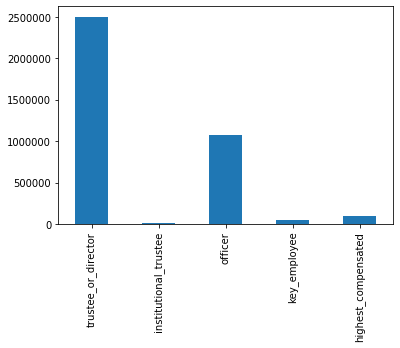

In [33]:
# what is the distribution
# based on the person receiving the compensation?
df.iloc[:, 3:8].notnull().sum().plot(kind='bar')

Trustee or director is the position with the highest number of rows in the dataset.

In [45]:
# remove positions I will not focus on at this time
# df.drop(['institutional_trustee',
#          'officer',
#          'key_employee',
#          'highest_compensated'], axis=1, inplace=True)

In [33]:
# how many trustees or directors
# received at least some compensation 
# in 2017?
df[(df.trustee_or_director == True) &
  (df.reportable_comp > 0) &
  (df.period.apply(lambda x: str(x)[0:4]) == '2017')
  ].shape

(40178, 20)

In [8]:
# subset dataset to focus analysis
df = df[(df.trustee_or_director == True) &
  (df.reportable_comp > 0) &
  (df.period.apply(lambda x: str(x)[0:4]) == '2017')
  ]

In [10]:
# examine data types
df.dtypes

ein                        int64
period                     int64
title                     object
trustee_or_director       object
institutional_trustee     object
officer                   object
key_employee              object
highest_compensated       object
reportable_comp          float64
org_name                  object
subsection                object
ntee_code                 object
ntee_description          object
state                     object
formation_yr             float64
assets                     int64
liabilities              float64
expenses                 float64
revenue                  float64
dtype: object

In [11]:
# examine for nan values
df.isna().sum()

ein                          0
period                       0
title                      268
trustee_or_director          0
institutional_trustee    40132
officer                  21157
key_employee             39288
highest_compensated      39551
reportable_comp              0
org_name                     0
subsection                   0
ntee_code                   81
ntee_description            81
state                      115
formation_yr              2253
assets                       0
liabilities                  0
expenses                     0
revenue                      0
dtype: int64

In [9]:
# drop rows with missing values in these columns
df.dropna(subset=['ntee_code'], inplace=True)

In [10]:
df.shape

(40097, 19)

In [11]:
# the small percentage of missing values 
# in these columns is acceptable to me
df.isna().mean()

ein                      0.000000
period                   0.000000
title                    0.006684
trustee_or_director      0.000000
institutional_trustee    0.998853
officer                  0.526274
key_employee             0.977804
highest_compensated      0.984363
reportable_comp          0.000000
org_name                 0.000000
subsection               0.000000
ntee_code                0.000000
ntee_description         0.000000
state                    0.002868
formation_yr             0.054767
assets                   0.000000
liabilities              0.000000
expenses                 0.000000
revenue                  0.000000
dtype: float64

In [76]:
df[df.formation_yr.isna()]

,ein,period,title,trustee_or_director,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
4433,10782751,201712,PRES/DIR-PPAC (AS OF 8/2017),True,414659.0,Nationwide Children's Hospital Group Return,501(c)(3),E24,"Hospital, Specialty",OH,NaN,4436425403,1.025159e+09,1.625978e+09,1.993501e+09,E
4437,10782751,201712,DIRECTOR - NCH,True,857183.0,Nationwide Children's Hospital Group Return,501(c)(3),E24,"Hospital, Specialty",OH,NaN,4436425403,1.025159e+09,1.625978e+09,1.993501e+09,E
4446,10782751,201712,PRES / DIRECTOR - CCFA,True,299907.0,Nationwide Children's Hospital Group Return,501(c)(3),E24,"Hospital, Specialty",OH,NaN,4436425403,1.025159e+09,1.625978e+09,1.993501e+09,E
4468,10782751,201712,DIRECTOR - CRI,True,577439.0,Nationwide Children's Hospital Group Return,501(c)(3),E24,"Hospital, Specialty",OH,NaN,4436425403,1.025159e+09,1.625978e+09,1.993501e+09,E
4480,10782751,201712,DIRECTOR - CSA,True,1073393.0,Nationwide Children's Hospital Group Return,501(c)(3),E24,"Hospital, Specialty",OH,NaN,4436425403,1.025159e+09,1.625978e+09,1.993501e+09,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3986856,990078610,201712,TRUSTEE KAUA,True,2816.0,INTERNATIONAL LONGSHORE & WAREHOUSE UNION LOCA...,501(c)(5),J40,"Labor Unions, Organizations",HI,NaN,31372448,5.560000e+04,1.360652e+07,1.737957e+07,J
3986857,990078610,201712,LEB PINEAPPL,True,3229.0,INTERNATIONAL LONGSHORE & WAREHOUSE UNION LOCA...,501(c)(5),J40,"Labor Unions, Organizations",HI,NaN,31372448,5.560000e+04,1.360652e+07,1.737957e+07,J
3986858,990078610,201712,IEB LONGSHOR,True,6103.0,INTERNATIONAL LONGSHORE & WAREHOUSE UNION LOCA...,501(c)(5),J40,"Labor Unions, Organizations",HI,NaN,31372448,5.560000e+04,1.360652e+07,1.737957e+07,J
3986859,990078610,201712,LEB PINEAPPL,True,2793.0,INTERNATIONAL LONGSHORE & WAREHOUSE UNION LOCA...,501(c)(5),J40,"Labor Unions, Organizations",HI,NaN,31372448,5.560000e+04,1.360652e+07,1.737957e+07,J


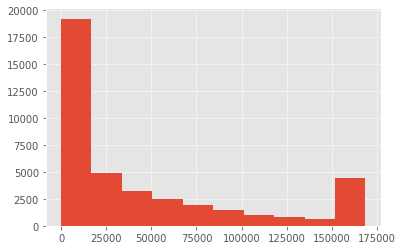

In [222]:
# clipping at the 90% percentile, what is the distribution?
plt.hist(df.reportable_comp.clip(upper=df.reportable_comp.quantile(.90)));

## FEATURE ENGINEERING

In [13]:
# to more broadly categorize not-for-profits
# strip off the letter from the ntee code
df['ntee_letter'] = df.ntee_code.apply(lambda x: x[0:1])

In [14]:
# based on ntee letters, which orgs have the most variance?
df.groupby('ntee_letter')['reportable_comp'].var() \
    .sort_values(ascending=False).reset_index()

,ntee_letter,reportable_comp
0,E,4.111779e+11
1,S,9.364884e+10
2,U,4.897066e+10
3,H,4.833287e+10
4,G,2.673913e+10
5,A,2.629700e+10
6,W,2.608796e+10
7,N,1.940259e+10
8,Q,1.643159e+10
9,V,1.625188e+10


In [62]:
df.head()

,ein,period,title,trustee_or_director,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
6,10877614,201712,BOARD MEMBER/MANAGING D,True,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
7,10877614,201712,BOARD MEMBER,True,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
154,10884383,201712,PRESIDENT,True,71062.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
158,10884383,201712,VICE PRESIDENT,True,9010.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
459,10906593,201712,VP OF FINANC,True,87452.0,MANAGEMENT SERVICES INC,501(c)(3),S02,Management and technical assistance - Communit...,CA,2008.0,4161179,120847.0,881055.0,795668.0,S


#### the number of people being paid from each subsection or NTEE category, essentially the competition for leadership for specific causes, this could be by location as well.  For instance NY pops up as the primary location for orgs of x type.

### titles with slashes, people doing multiple roles - which categories of orgs are these most common with?

In [28]:
df.sort_values(by='reportable_comp')

,ein,period,title,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
3768887,931293019,201712,PRESIDENT,True,NaN,True,NaN,NaN,1.0,CASCADIA WILDLANDS,501(c)(3),C30,Natural Resources Conservation and Protection,OR,NaN,279610,8.430000e+03,3.146850e+05,4.054140e+05,C
3768886,931293019,201712,DIRECTOR,True,NaN,NaN,NaN,NaN,1.0,CASCADIA WILDLANDS,501(c)(3),C30,Natural Resources Conservation and Protection,OR,NaN,279610,8.430000e+03,3.146850e+05,4.054140e+05,C
3768885,931293019,201712,DIRECTOR,True,NaN,NaN,NaN,NaN,1.0,CASCADIA WILDLANDS,501(c)(3),C30,Natural Resources Conservation and Protection,OR,NaN,279610,8.430000e+03,3.146850e+05,4.054140e+05,C
3768883,931293019,201712,SECRETARY,True,NaN,True,NaN,NaN,1.0,CASCADIA WILDLANDS,501(c)(3),C30,Natural Resources Conservation and Protection,OR,NaN,279610,8.430000e+03,3.146850e+05,4.054140e+05,C
3768882,931293019,201712,TREASURER,True,NaN,True,NaN,NaN,1.0,CASCADIA WILDLANDS,501(c)(3),C30,Natural Resources Conservation and Protection,OR,NaN,279610,8.430000e+03,3.146850e+05,4.054140e+05,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616766,362169147,201712,"President & CEO, Director",True,NaN,True,NaN,NaN,10051752.0,Advocate Health and Hospitals Corp,501(c)(3),E21,Community Health Systems,IL,1906.0,8519791827,3.505025e+09,5.067261e+09,5.310395e+09,E
1769265,391442285,201712,"CEO, Ex Officio Director",True,NaN,True,NaN,NaN,10663333.0,Aurora Health Care Inc,501(c)(3),E21,Community Health Systems,WI,1983.0,2862260073,5.001537e+09,1.107903e+09,1.191046e+09,E
3814863,941340523,201712,Chairman & CEO,True,NaN,True,NaN,NaN,10709503.0,KAISER FOUNDATION HEALTH PLAN INC,501(c)(3),E31,Group Health Practice (Health Maintenance Orga...,CA,1955.0,21117803253,1.956054e+10,5.376456e+10,5.398362e+10,E
3223575,741152597,201706,Special Advisor,True,NaN,True,NaN,NaN,18169121.0,Memorial Hermann Health System,501(c)(3),E21,Community Health Systems,TX,1910.0,6890878241,3.333684e+09,4.342562e+09,4.535430e+09,E


In [15]:
df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sort_values(ascending=False).head(50)

subsection  ntee_letter
501(c)(3)   E              1.243143e+09
501(c)(5)   J              1.728740e+08
501(c)(3)   P              1.613450e+08
501(c)(6)   S              1.594436e+08
501(c)(3)   B              1.454632e+08
            X              9.888558e+07
            A              9.664789e+07
            G              7.061672e+07
            Q              6.375370e+07
501(c)(12)  W              6.145959e+07
501(c)(3)   S              5.254884e+07
            T              4.771697e+07
            L              4.415746e+07
501(c)(14)  W              3.954823e+07
501(c)(4)   E              3.923740e+07
501(c)(3)   N              3.916216e+07
            F              3.734354e+07
            H              3.212459e+07
            U              3.188284e+07
            C              3.089104e+07
501(c)(8)   Y              2.949053e+07
501(c)(3)   W              2.907653e+07
501(c)(6)   E              2.809381e+07
501(c)(3)   O              2.699564e+07
501(c)(6)   W   

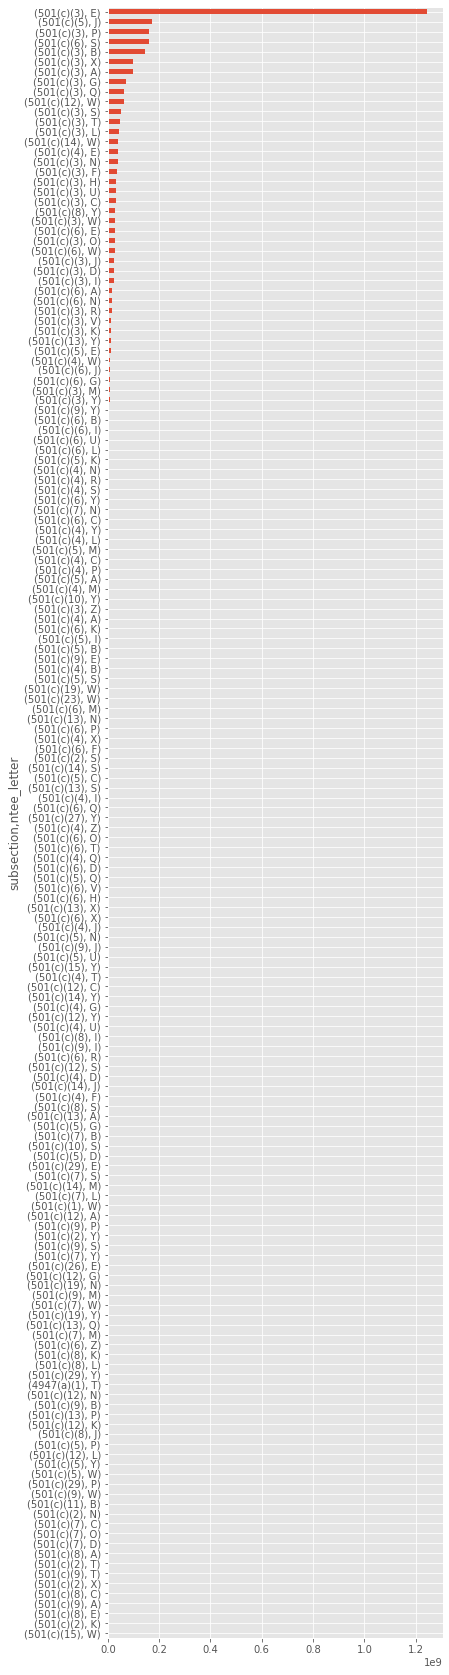

In [24]:
fig, ax = plt.subplots(figsize=(6, 30))

ax = df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sort_values().plot(kind='barh')

Most significant salaries are received by a relatively small subset of not-for-profits.

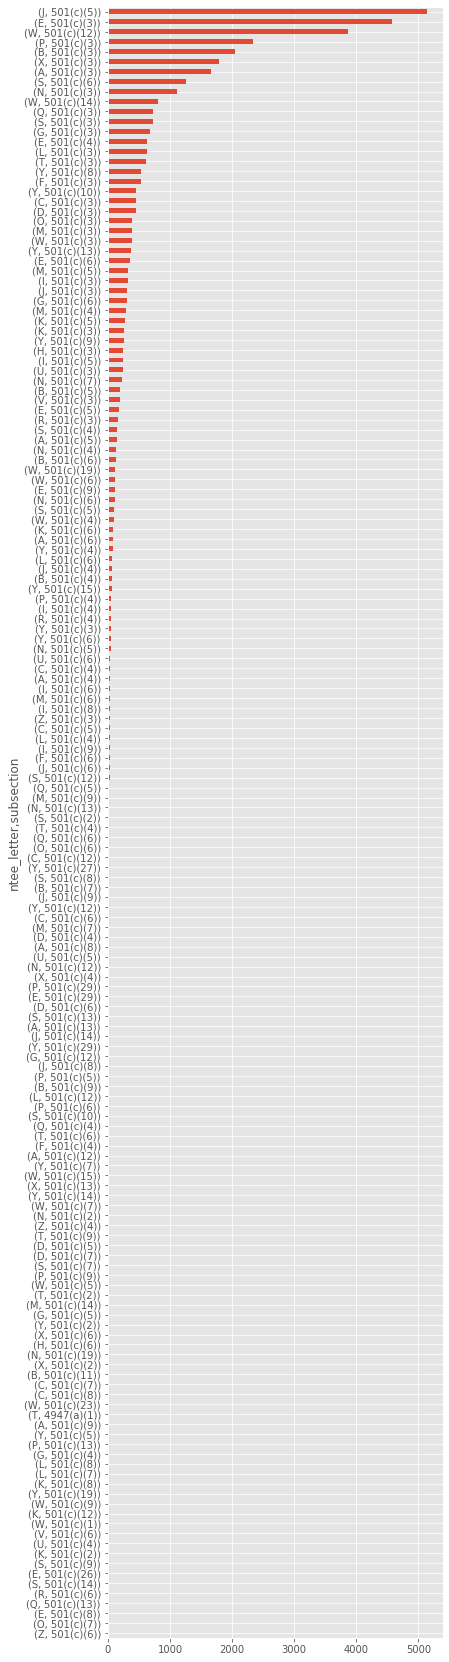

In [25]:
fig, ax = plt.subplots(figsize=(6, 30))

ax = df.groupby(['ntee_letter', 'subsection'])['reportable_comp'].count().sort_values().plot(kind='barh')

### EXPORT DATASET FOR MODELING

cleaned/organized dataset with added features - export for modeling

In [16]:
df.to_csv('02.data/executive_comp_data.csv', index=False)

### Title analysis
This is a fill in the blank field, as a result there are a huge number of unique values.

In [73]:
df.title.nunique()

7035

In [357]:
df.title.value_counts().head(10)

DIRECTOR              5518
PRESIDENT             2353
Director              2170
TRUSTEE               1702
BOARD MEMBER          1507
EXECUTIVE DIRECTOR    1452
SECRETARY             1115
TREASURER             1057
President             1009
VICE PRESIDENT         832
Name: title, dtype: int64

In [356]:
# how many trustees/directors
# have multiple roles listed within their title?
df[(~df.title.isna()) &
  (df.title.str.contains('/'))].shape

(4140, 16)

### Verify I can join governance EINs with Executive comp EINs

In [130]:
ein = pd.read_csv('data_sets/ein.csv')

In [131]:
ein.set_index('ein').index.intersection(df['ein'].reset_index().set_index('ein').index)

Int64Index([ 61594980,  61594980, 311424220, 311424220, 311424220, 311424220,
            141056009, 141056009, 141056009, 141056009,
            ...
            952149001, 952149001, 952149001,  43528015, 472330028, 475285597,
            474202980, 474202980, 474202980, 364735749],
           dtype='int64', name='ein', length=38625)

### SPARE PARTS